# Big Data and Automated Content Analysis I+II, Week 10

(c) Damian Trilling

This notebook illustrates how to determine a cutoff point for logistic regression. Refer to the lecture slides for context.

We use the same data and the same example as in week 9 as starting point.

In [1]:
from glob import glob
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Create data set

In [2]:
reviews=[]
test=[]

print("Constructing training dataset")

# glob gives you a list of filenames that match a specific criterion
# in this case, all .txt-files in the postivie training folder

for file in glob ("/home/damian/Downloads/aclImdb/train/pos/*.txt"):
    with open(file) as fi:
        reviews.append((fi.read(),"1"))
nopostr=len(reviews)

print ("Added",nopostr,"positive reviews")  

for file in glob ("/home/damian/Downloads/aclImdb/train/neg/*.txt"):
    with open(file) as fi:
        reviews.append((fi.read(),"-1"))
nonegtr=len(reviews)-nopostr
print ("Added",nonegtr,"negative reviews")  
   
print("Constructing test dataset")

for file in glob ("/home/damian/Downloads/aclImdb/test/pos/*.txt"):
    with open(file) as fi:
        test.append((fi.read(),"1"))
noposte=len(test)
print ("Added",noposte,"positive reviews")  

for file in glob ("/home/damian/Downloads/aclImdb/test/neg/*.txt"):
    with open(file) as fi:
        test.append((fi.read(),"-1"))
nonegte=len(test)-noposte
print ("Added",nonegte,"negative reviews")  

Constructing training dataset
Added 12500 positive reviews
Added 12500 negative reviews
Constructing test dataset
Added 12500 positive reviews
Added 12500 negative reviews


## Fit vectorizer and model

In [3]:
# Generate BOW representation of word counts
vectorizer = CountVectorizer(stop_words='english')   
#alternatively, you could provide a list of stop words yourself
train_features = vectorizer.fit_transform([r[0] for r in reviews])
test_features = vectorizer.transform([r[0] for r in test])

# Fit a naive bayes model to the training data.
clf = LogisticRegression()
clf.fit(train_features, [r[1] for r in reviews])


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Get predictions from default model

In [4]:
predictions = clf.predict(test_features)
actual=[r[1] for r in test]

In [5]:
print('Precision:')
print(metrics.precision_score(actual,predictions,pos_label='1', labels = ['-1','1']))
print('Recall:')
print(metrics.recall_score(actual,predictions,pos_label='1', labels = ['-1','1']))


Precision:
0.8655427966446779
Recall:
0.85024


In [6]:
# another way of doint it
print(metrics.classification_report(actual, predictions))

             precision    recall  f1-score   support

         -1       0.85      0.87      0.86     12500
          1       0.87      0.85      0.86     12500

avg / total       0.86      0.86      0.86     25000



Let's also get the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix#Table_of_confusion) (a crosstab of predicted and actual values). Indeed,  we see that thinking a good movie is bad is a bit less of a problem than the other way around. But it actually looks kind of balanced already.

In [7]:
print(metrics.confusion_matrix(actual,predictions))

[[10849  1651]
 [ 1872 10628]]


## Get predicted probabilites and plot an ROC curve

In [8]:
predprobs = clf.predict_log_proba(test_features)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1356: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))


In [9]:
predprobs

array([[-2.54891875e+00, -8.13902641e-02],
       [-9.43651861e+00, -7.97607739e-05],
       [-5.04399889e+00, -6.46878976e-03],
       ...,
       [-3.85668818e-02, -3.27458282e+00],
       [-1.82818971e-01, -1.78927611e+00],
       [-1.70108739e-01, -1.85516636e+00]])

In [10]:
fpr,tpr, thresholds = metrics.roc_curve([r[1] for r in test], predprobs[:,1], pos_label='1')
roc_auc = metrics.auc(fpr,tpr)
print("ROC AUC: {}".format(roc_auc))

ROC AUC: 0.9294683840000001


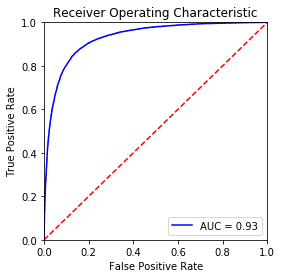

In [11]:
plt.figure(figsize=(4,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr,'b',label='AUC = %0.2f'%roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig('roccurve.svg')
plt.show()

### Finding the threshold value: the eyeballing method

The plot shows that TPR of approx .85 might be good. We could check by printing the corresponding threshold value to each false-positive-rate/true-positive-rate combination and then spotting the appropriate threshold:

In [12]:
# DO NOT (NOT, NOT, NOT) PRINT ALL OF THIS IN ANY FINAL ASSIGNMENT....
# RATHER CONSTRUCT A SMART FILTER THAT PRINTS ONLY PARTS OF IT
for f, t, th in zip(fpr,tpr, thresholds):
    print('{}\t{}\t{}'.format(f,t,th))

0.0	0.00016	0.0
0.0	0.0004	-2.2204460492503136e-16
0.0	0.00056	-8.881784197001256e-16
0.0	0.0008	-1.776356839400252e-15
0.0	0.00976	-1.3470022883956156e-09
8e-05	0.00976	-1.353643420493286e-09
8e-05	0.01224	-3.1136309135050317e-09
0.00016	0.01224	-3.122738295049035e-09
0.00016	0.01952	-4.607774612551202e-08
0.00024	0.01952	-4.707920475488626e-08
0.00024	0.0272	-2.111701043836691e-07
0.00024	0.02736	-2.1666482368402856e-07
0.00024	0.02904	-2.529437006673743e-07
0.00032	0.02904	-2.5577975400373164e-07
0.00032	0.03384	-6.221501439819873e-07
0.0004	0.03384	-6.258282805187289e-07
0.0004	0.03392	-6.282194580530086e-07
0.00048	0.03392	-6.336537329589464e-07
0.00048	0.03608	-8.549230397670109e-07
0.00048	0.03624	-8.58671523171611e-07
0.00048	0.03848	-1.1132330810797365e-06
0.00056	0.03848	-1.116019170324755e-06
0.00056	0.0416	-1.584105228133912e-06
0.00064	0.0416	-1.5876583825439943e-06
0.00064	0.04216	-1.6989230565600943e-06
0.00072	0.04216	-1.732477183096631e-06
0.00072	0.04584	-2.4061858622

0.15928	0.87672	-0.9533743545191127
0.15928	0.87688	-0.9542488675733264
0.15936	0.87688	-0.9544158905794902
0.15936	0.87696	-0.9550999838613594
0.15944	0.87696	-0.9552284416937735
0.15944	0.87704	-0.9553774284531998
0.1596	0.87704	-0.9567732563669481
0.1596	0.87712	-0.9575424852634
0.15992	0.87712	-0.9580901366980008
0.16008	0.87712	-0.9582419338006207
0.16024	0.87712	-0.959676767377464
0.16024	0.87728	-0.9606888254174251
0.1604	0.87728	-0.9618582693099403
0.1604	0.87736	-0.9618842076648118
0.16064	0.87736	-0.9625303732741495
0.1608	0.87736	-0.962701405086469
0.1608	0.87744	-0.9629124858449983
0.16096	0.87744	-0.9633830313954571
0.16096	0.87776	-0.965762464733563
0.16104	0.87776	-0.9657676528069298
0.16104	0.87784	-0.9662371043245364
0.16112	0.87784	-0.9662764540809343
0.16112	0.87808	-0.9681325441787649
0.16128	0.87808	-0.9687888365977863
0.16136	0.87808	-0.9692003976492635
0.16136	0.87816	-0.9702441984674663
0.16144	0.87816	-0.9702458015208583
0.16144	0.8784	-0.972767094766667
0.1616

0.52864	0.98168	-5.027339483119196
0.52864	0.98176	-5.027528006531442
0.5292	0.98176	-5.030303823288049
0.5292	0.98192	-5.031061082768025
0.52952	0.98192	-5.034833491808127
0.52952	0.982	-5.035814168538618
0.53056	0.982	-5.045242172180191
0.53056	0.98208	-5.047130973467832
0.53144	0.98208	-5.052905075864682
0.53144	0.98216	-5.052951783560069
0.5324	0.98216	-5.069995973458343
0.5324	0.98224	-5.070129522352463
0.53336	0.98224	-5.080171672041205
0.53336	0.98232	-5.080520877238627
0.53368	0.98232	-5.087845686228632
0.53368	0.9824	-5.087946801612167
0.53592	0.9824	-5.104555848609532
0.53592	0.98248	-5.104620524311172
0.5364	0.98248	-5.1136580537974154
0.5364	0.98256	-5.114578979887092
0.53648	0.98256	-5.11747371661523
0.53648	0.98264	-5.117523998739494
0.53832	0.98264	-5.140068704547988
0.53832	0.98272	-5.141386283096378
0.5392	0.98272	-5.154690198840292
0.5392	0.9828	-5.156332217998068
0.54008	0.9828	-5.1680830343959645
0.54008	0.98296	-5.169138224291781
0.54048	0.98296	-5.171167326960022


Looks like it's something around -0.7. That would be a FPR of 13% and a TPR of 85%.
Wait, -0,7? What does that mean? We need to exponentiate:

In [13]:
np.exp(-0.7)

0.4965853037914095

This looks very close to our default cutoff of 0.5 (and that makes sense, given our confusion matrix above).
Let's check the other way round:

In [14]:
np.log(0.5)

-0.6931471805599453

### Finding the threshold value: finding the maximum differnence between TPR and FPR

Rather than staring at this large table, we could also try to maximize the difference between TPR and FPR and look up which threshold belongs to it. In other words: we find the row in the table above with the biggest difference between the first two columns and print the value in the third column.

In [15]:
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)

-0.7595481127352712


This approach is also known as Youden's J. An alternative implementation without using `numpy` could be:

In [1]:
def get_optimal_threshold(fpr,tpr,thresholds):
    j_scroes = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]    # return threshold score of the last (i.e., highest j_score)_ot

optimal_threshold2 = get_optimal_threshold(fpr,tpr,thresholds)
print(optimal_threshold)

In [16]:
np.exp(optimal_threshold)

0.4678778072688427

Looks like we can go even a bit lower with our threshold than we expected. Let's try:

In [17]:
predictions_new = np.where(predprobs[:,1] > optimal_threshold, '1', '-1')

In [18]:
print('WITH THRESHOLD OF {}'.format(np.exp(optimal_threshold)))
print('-'*60)
print(metrics.confusion_matrix(actual,predictions_new))
print(metrics.precision_score(actual, predictions_new, pos_label='1'))
print(metrics.recall_score(actual,predictions_new, pos_label='1'))

WITH THRESHOLD OF 0.4678778072688427
------------------------------------------------------------
[[10758  1742]
 [ 1759 10741]]
0.8604502122887127
0.85928


Yeah! Looks like we have slightly more balanced predictions now! We got a minimally worse precision but and a minimally better precision.

Using our new cutoff point makes our classifier *equally good in predicting good and bad movies*, which was not the case before.

In [19]:
print('WITH THRESHOLD OF .50')
print('-'*60)
print(metrics.confusion_matrix(actual,predictions))
print(metrics.precision_score(actual, predictions, pos_label='1'))
print(metrics.recall_score(actual,predictions, pos_label='1'))

WITH THRESHOLD OF .50
------------------------------------------------------------
[[10849  1651]
 [ 1872 10628]]
0.8655427966446779
0.85024
